In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

 # Ground Truth

In [8]:
def iterate_and_save_frame(video_path, start_time, end_time, num_frames, filepath, fps):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    for i in tqdm(range(num_frames)):
        ret, frame = cap.read()
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame + i * (end_frame - start_frame) // num_frames)

    cv2.imwrite(filepath, frame)
    cap.release()


video_path = '../video/Mario_Kart.mp4'
fps = 30
start = 75
end = 125

i=0
while start + 3*i < end:
    iterate_and_save_frame(video_path, start + 3*i, start + 3*i + 0.5, 15, '../img/evaluation/images/image_' + str(i) + '.jpg', fps)
    i += 1

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:01<00:00, 14.93it/s]


# Boykov Kolmogorov

In [2]:
# Change dir
os.chdir('../BoykovKolmogorov')
from graph_cut import BoykovKolmorogov
from img_to_graph import img_to_graph
from utils import get_mask, process_mask
from GUI import GUI_seeds

marked_ob_pixels [(201, 317), (202, 317), (203, 317), (204, 317), (206, 317), (207, 317), (208, 317), (209, 317), (210, 317), (211, 316), (211, 315), (212, 315), (213, 314), (214, 314), (214, 313), (215, 313), (216, 312), (217, 311), (218, 311), (218, 310), (219, 310), (220, 310), (221, 310), (221, 309), (222, 309), (222, 308), (223, 307), (224, 307), (225, 307), (225, 306), (226, 306), (227, 305), (228, 305), (229, 304), (230, 303), (231, 303), (232, 302), (234, 302), (235, 300), (235, 299), (236, 299), (237, 299), (238, 299), (238, 298), (240, 297), (241, 297), (242, 297), (242, 296), (243, 296), (244, 296), (244, 295), (245, 295), (245, 294), (246, 294), (246, 293), (247, 293), (247, 292), (248, 292), (248, 291), (249, 291), (250, 291), (252, 290), (254, 289), (255, 289), (256, 288), (257, 288), (258, 287), (258, 286), (259, 286), (260, 286), (261, 286), (262, 285), (263, 285), (263, 286), (264, 286), (265, 286), (266, 287), (266, 288), (266, 289), (267, 290), (268, 290), (268, 291)

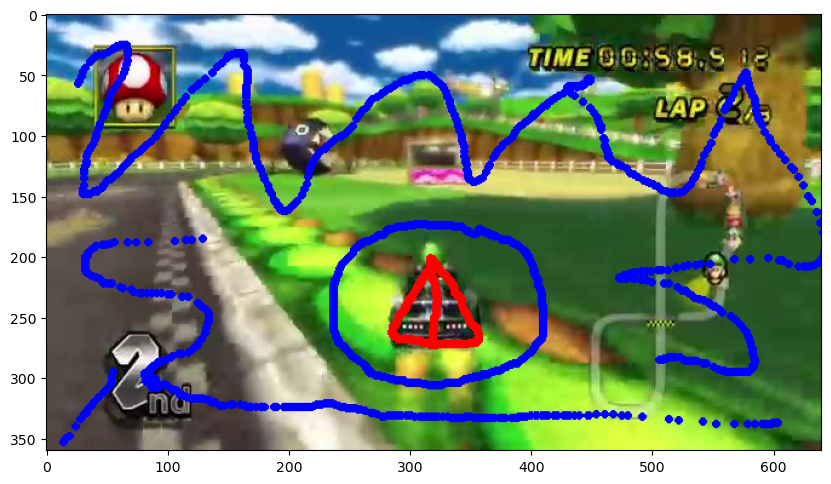

In [4]:
inputfile = '../img/mario_in/mario_in_30.JPG'

GUI = GUI_seeds(inputfile)
marked_ob_pixels, marked_bg_pixels, labelled_image = GUI.labelling()
print("marked_ob_pixels", marked_ob_pixels)
print("marked_bg_pixels", marked_bg_pixels)

plt.figure(figsize=(10,15))
plt.imshow(labelled_image[...,::-1])
plt.show()

In [5]:
def iterate_and_save_frame(video_path, start_time, end_time, num_frames, maskpath, overlaypath, fps, threshold=2500):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    previous_mask = None

    for i in tqdm(range(num_frames)):
        ret, frame = cap.read()
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame + i * (end_frame - start_frame) // num_frames)
        if ret:
            try:
                G, s, t, _, _ = img_to_graph(frame, marked_ob_pixels, marked_bg_pixels, region_size=20)
                G_residual = BoykovKolmorogov(G, s, t, capacity='sim').max_flow()

                current_mask = get_mask(frame, G, G_residual)
                if previous_mask is not None:
                    mask = cv2.bitwise_and(previous_mask, current_mask)
                    previous_mask = current_mask
                else:
                    mask = current_mask
                    previous_mask = current_mask

                # change shape to (height, width, 3)
                mask = process_mask(mask, threshold)
                mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
                image_mask = np.where(mask == 1, frame, frame//4)
            except:
                print(f"Error processing frame {i}")

    cv2.imwrite(maskpath, mask)
    cv2.imwrite(overlaypath, image_mask)

    cap.release()


video_path = '../video/Mario_Kart.mp4'
fps = 30
start = 75
end = 125

i=0
while start + 3*i < end:
    iterate_and_save_frame(video_path,
                           start + 3*i,
                           start + 3*i + 0.5,
                           15,
                           '../img/evaluation/mask_BK/image_' + str(i) + '.jpg',
                            '../img/evaluation/overlay_BK/image_' + str(i) + '.jpg',
                           fps)
    i += 1

 73%|███████▎  | 11/15 [00:32<00:10,  2.61s/it]

Error processing frame 10


 27%|██▋       | 4/15 [00:11<00:25,  2.30s/it]

Error processing frame 3


 47%|████▋     | 7/15 [00:19<00:18,  2.35s/it]

Error processing frame 6


 80%|████████  | 12/15 [00:43<00:09,  3.29s/it]

Error processing frame 11


100%|██████████| 15/15 [01:12<00:00,  4.86s/it]


# Tree based method

In [21]:
# Change dir
os.chdir('../Chiara')
from model import *
from preprocessing import get_segmented_image
from PIL import ImageFilter
import cv2
from PIL import Image as PILImage
import io

In [22]:
def get_mask_ter(forest, init_image, original_image,fac,verbose=True):
    from collections import defaultdict

    height,width = original_image.size

    components_points = defaultdict(list)
    components_centers = {}

    for y in range(height):
        for x in range(width):
            comp = forest.find(y * width + x)        
            components_points[comp].append((x, y))

    for comp, points in components_points.items():
        avg_x = sum(point[0] for point in points) / len(points)
        avg_y = sum(point[1] for point in points) / len(points)
        
        components_centers[comp] = (avg_x, avg_y)

    filtered_components = {comp: points for comp, points in components_points.items() if len(points) < 1000}

    centre_x = 60 #width // 2
    centre_y = 80 #height *2 // 3

    distances = {comp: ((centre_x - center[0]) ** 2 + (centre_y - center[1]) ** 2) ** 0.5 for comp, center in components_centers.items() if comp in filtered_components}
    sorted_components = sorted(distances.items(), key=lambda x: x[1])

    # for comp, distance in sorted_components:
    #     print(f"Composante {comp}: Distance au point défini = {distance} et taille = {len(filtered_components[comp])}")
    if len(sorted_components) == 0:
        return init_image
    chosen = sorted_components[0][0]
    # print(chosen)
    mask = np.zeros((width,height))
    g=256
    for points in components_points[chosen]:
                    mask[points] = 1
    mask_big = cv2.resize(mask, (fac*height, fac*width), interpolation=cv2.INTER_NEAREST)
    #change shape to (height, width, 3)
    mask_big = np.stack([mask_big]*3, axis=-1)
    return mask_big


def get_mask(forest, original_image):
    comp_list=[]
    height,width = original_image.size
    for y in range(height):
        for x in range(width):
            comp = forest.find(y * width + x)
            comp_list.append(comp)

    unique, counts = np.unique(comp_list, return_counts=True)
    dictio=dict(zip(unique, counts))
    majority_comp = max(dictio, key=dictio.get)
    mask=np.zeros((width,height))
    for y in range(height):
        for x in range(width):
            comp = forest.find(y * width + x)
            mask[x,y]=int(comp==majority_comp)
    return mask

def get_green_mask(image_array, hue_range=(35, 90)):
    hsv_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2HSV)
    hue_channel = hsv_image[:, :, 0]
    lower_hue, upper_hue = hue_range
    green_mask = cv2.inRange(hue_channel, lower_hue, upper_hue)
    return green_mask

In [8]:
params1 = {
    'sigma': 7,
    'neighbor': 4,
    'K': 1e-2,
    'min_comp_size': 800
}

params2 = {
    'sigma': 1,
    'neighbor': 8,
    'K': 1e3,
    'min_comp_size': 100
}

paramst = {
    'sigma': 7,
    'neighbor': 4,
    'K': 1e3,
    'min_comp_size': 800
}

In [24]:
def iterate_frames(video_path, start_time, end_time, num_frames, mask_path, overlay_path,params1,params2,verbose=False):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    previous_threshold=None
    for i in range(num_frames):
        ret, frame = cap.read()
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame + i * (end_frame - start_frame) // num_frames)
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # filename = f'mario_in_{i}.npy'
            # filepath = os.path.join('../img/mario_in', filename)
            # np.save(filepath,frame_rgb)

            init_image = PILImage.fromarray(frame_rgb).convert("RGB")
            fac=4            
            pil_image = init_image.resize((int(init_image.size[0]/fac),int(init_image.size[1]/fac)))

            new_image= np.array(pil_image)
            if i==0:
                forest,_=get_segmented_image(params1, pil_image,verbose,previous_threshold=None)
                mask=get_mask(forest,pil_image)
                new_image[mask == 0] = [0, 0, 0]            
            green_mask=get_green_mask(new_image,hue_range=(40, 85))
            im=new_image.copy()
            im[green_mask == 0] = [0, 0, 0]

            forest,t=get_segmented_image(params2, im,verbose,previous_threshold=previous_threshold)
            mask_big=get_mask_ter(forest, init_image,pil_image,fac,verbose)
            image_mask = np.where(mask_big == 1, frame, frame//4)

        else:
            print("Fin de la vidéo.")
            break

    cv2.imwrite(mask_path, mask_big)
    cv2.imwrite(overlay_path, image_mask)
    cap.release()

video_path = '../video/Mario_Kart.mp4'
fps = 30
start = 75
end = 125

i=0
while start + 3*i < end:
    iterate_frames(video_path,
                   start + 3*i,
                   start + 3*i + 0.5,
                   15,
                   '../img/evaluation/mask_TB/image_' + str(i) + '.jpg',
                   '../img/evaluation/overlay_TB/image_' + str(i) + '.jpg',
                   params1,
                   params2,
                   verbose=False)
    i += 1

# Compute metrics

In [25]:
import json

In [26]:
def miuo(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    return np.count_nonzero(intersection) / np.count_nonzero(union)


def get_mask_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # Initialize mask array
    image_shape = (data['imageHeight'], data['imageWidth'])
    mask = np.zeros(image_shape, dtype=np.uint8)
    
    # Extract polygon coordinates
    for shape in data['shapes']:
        polygon_points = shape['points']
        polygon_points = np.array(polygon_points, np.int32)
        polygon_points = polygon_points.reshape((-1, 1, 2))
        
        # Create mask for the current polygon
        cv2.fillPoly(mask, [polygon_points], 1)
    
    return mask


def get_mask_png(png_file):
    mask = cv2.imread(png_file, cv2.IMREAD_GRAYSCALE)
    mask = np.where(mask > 0, 1, 0)
    return mask

In [32]:
images_clean = [f'image_{i}' for i in range(15)]

miuo_values_BK = []
miuo_values_TB = []

for image in images_clean:
    mask_GT = get_mask_json(f'../img/evaluation/mask_GT/{image}.json')
    mask_BK = get_mask_png(f'../img/evaluation/mask_BK/{image}.jpg')
    mask_TB = get_mask_png(f'../img/evaluation/mask_TB/{image}.jpg')

    miuo_values_BK.append(miuo(mask_GT, mask_BK))
    miuo_values_TB.append(miuo(mask_GT, mask_TB))

print(f"Mean MIUO BK: {np.mean(miuo_values_BK)} +- {np.std(miuo_values_BK)}")
print(f"Mean MIUO TB: {np.mean(miuo_values_TB)} +- {np.std(miuo_values_TB)}")

Mean MIUO BK: 0.59448275767369 +- 0.2069681454749391
Mean MIUO TB: 0.5828214479289067 +- 0.24423949070460035
